In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("teamincribo/cyber-security-attacks")
completedpath = path+"/cybersecurity_attacks.csv"

print("Path to dataset files:", path)

100%|██████████| 5.03M/5.03M [00:00<00:00, 36.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/teamincribo/cyber-security-attacks/versions/14


In [3]:
df = pd.read_csv(completedpath)

In [4]:
df['Network Segment'] = df['Network Segment'].replace({
    'Segment A': 'Database',
    'Segment B': 'Internal Functions',
    'Segment C': 'External Functions'
})

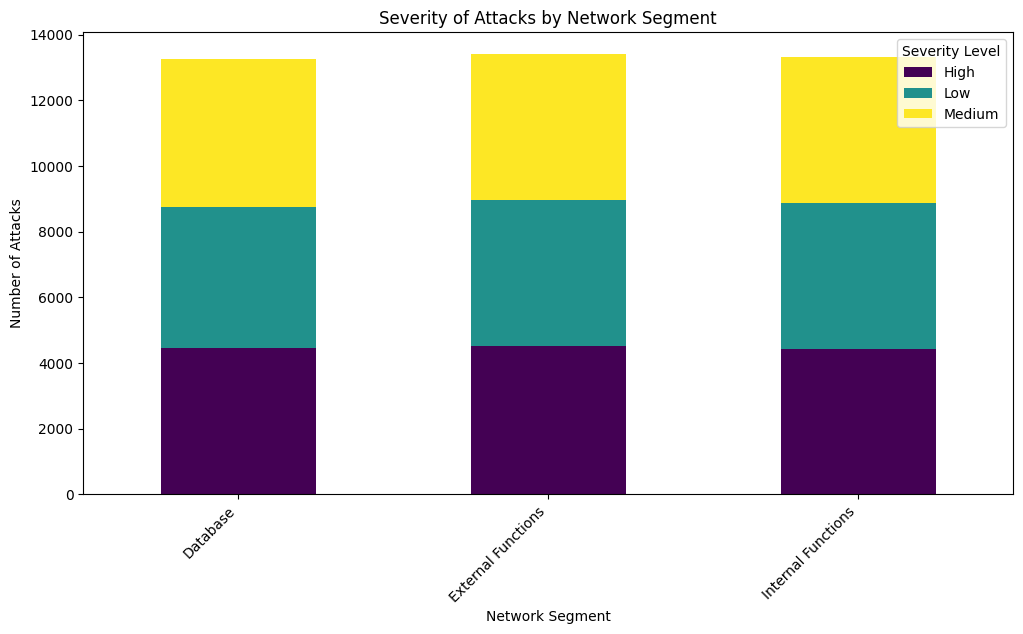

In [5]:
# Step 4: Severity of Attacks by Network Segment
plt.figure(figsize=(12, 6))
severity_by_segment = df.groupby(['Network Segment', 'Severity Level']).size().unstack(fill_value=0)
severity_by_segment.plot(kind='bar', stacked=True, colormap='viridis', ax=plt.gca())
plt.title('Severity of Attacks by Network Segment')
plt.xlabel('Network Segment')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Number of Attacks')
plt.legend(title='Severity Level')
plt.show()

In [6]:
# Group by 'Network Segment' and 'Severity Level' and count occurrences
severity_by_segment = df.groupby(['Network Segment', 'Severity Level']).size().unstack(fill_value=0)

# Add a total column
severity_by_segment['Total Attacks'] = severity_by_segment.sum(axis=1)

# Print the table
print("Severity of Attacks by Network Segment:")
print(severity_by_segment)

Severity of Attacks by Network Segment:
Severity Level      High   Low  Medium  Total Attacks
Network Segment                                      
Database            4444  4295    4534          13273
External Functions  4523  4425    4460          13408
Internal Functions  4415  4463    4441          13319


In [7]:
# Chi-square test for independence between severity and network segment
chi2, p, dof, ex = stats.chi2_contingency(severity_by_segment)
print(f"Chi-square Test: chi2={chi2:.2f}, p={p:.4f}, degrees of freedom={dof}")
print("Conclusion: Significant relationship" if p < 0.05 else "Conclusion: No significant relationship")

Chi-square Test: chi2=5.32, p=0.5041, degrees of freedom=6
Conclusion: No significant relationship


<ipython-input-8-12d389e8bc3c>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=attack_type_counts.values, y=attack_type_counts.index, palette='coolwarm')


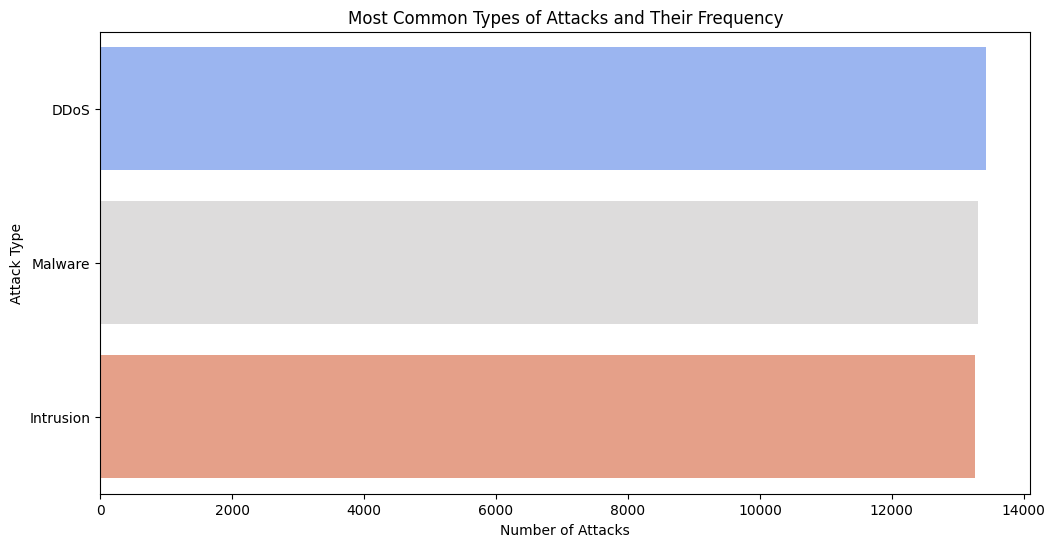

In [8]:
# Step 5: Most Common Attack Types and Their Frequency
plt.figure(figsize=(12, 6))
attack_type_counts = df['Attack Type'].value_counts().head(10)
sns.barplot(x=attack_type_counts.values, y=attack_type_counts.index, palette='coolwarm')
plt.title('Most Common Types of Attacks and Their Frequency')
plt.xlabel('Number of Attacks')
plt.ylabel('Attack Type')
plt.show()

In [9]:
# Step 6: Descriptive statistics for Attack Type frequency
print("\nDescriptive Statistics for Top 3 Attack Types:")
print(attack_type_counts.describe())


Descriptive Statistics for Top 3 Attack Types:
count        3.000000
mean     13333.333333
std         84.630570
min      13265.000000
25%      13286.000000
50%      13307.000000
75%      13367.500000
max      13428.000000
Name: count, dtype: float64


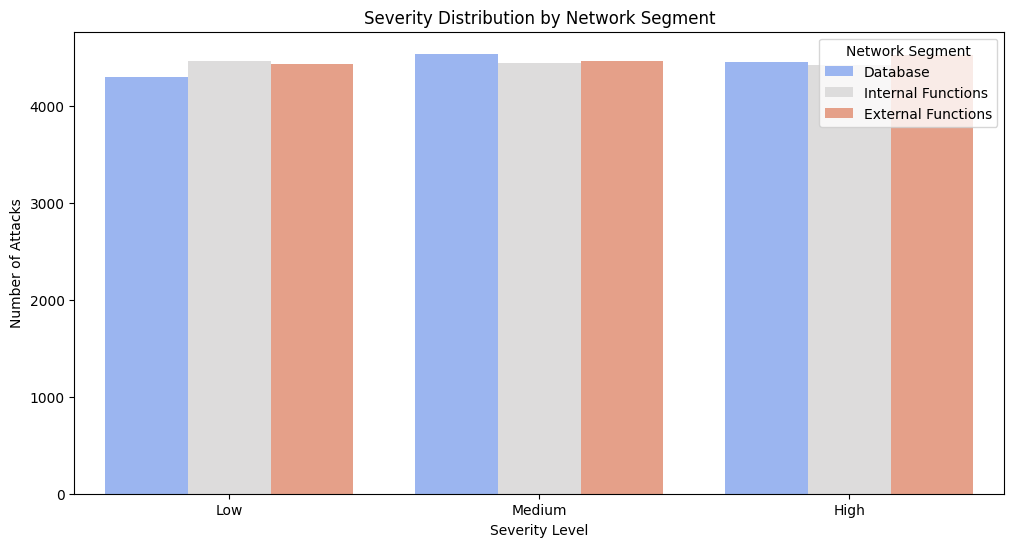

In [10]:
# Severity Distribution across All Network Segments
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Severity Level', hue='Network Segment', palette='coolwarm')
plt.title('Severity Distribution by Network Segment')
plt.xlabel('Severity Level')
plt.ylabel('Number of Attacks')
plt.show()

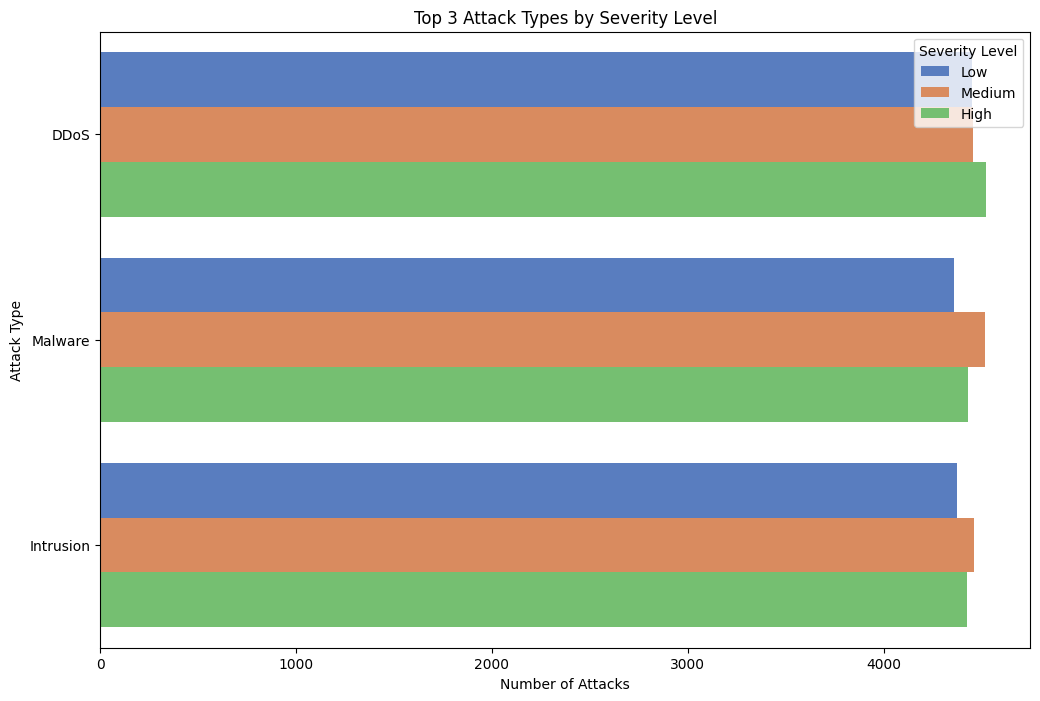

In [11]:
# Distribution of Attack Types by Severity Level
plt.figure(figsize=(12, 8))
sns.countplot(data=df, y='Attack Type', hue='Severity Level', order=df['Attack Type'].value_counts().index[:10], palette='muted')
plt.title('Top 3 Attack Types by Severity Level')
plt.xlabel('Number of Attacks')
plt.ylabel('Attack Type')
plt.legend(title='Severity Level')
plt.show()

In [12]:
# Group by 'Attack Type' and count occurrences
attack_type_counts = df.groupby('Attack Type').size()

# Print the table
print("Total Attacks by Attack Type:")
print(attack_type_counts)

Total Attacks by Attack Type:
Attack Type
DDoS         13428
Intrusion    13265
Malware      13307
dtype: int64


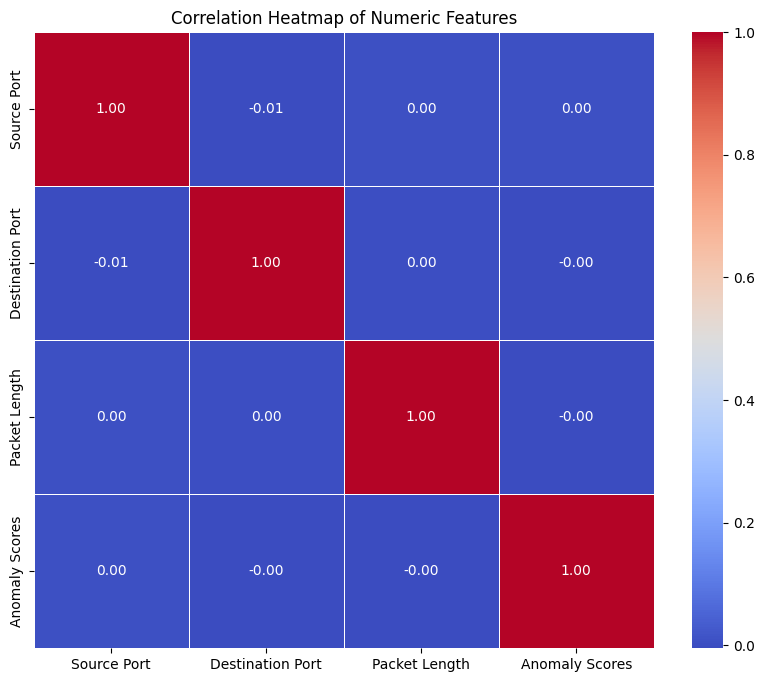

In [13]:
# Correlation Heatmap
plt.figure(figsize=(10, 8))
numeric_cols = df.select_dtypes(include=['int64', 'float64'])
correlation_matrix = numeric_cols.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

<ipython-input-14-f022a4a3260b>:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  time_series = df.resample('M', on='Timestamp').size()


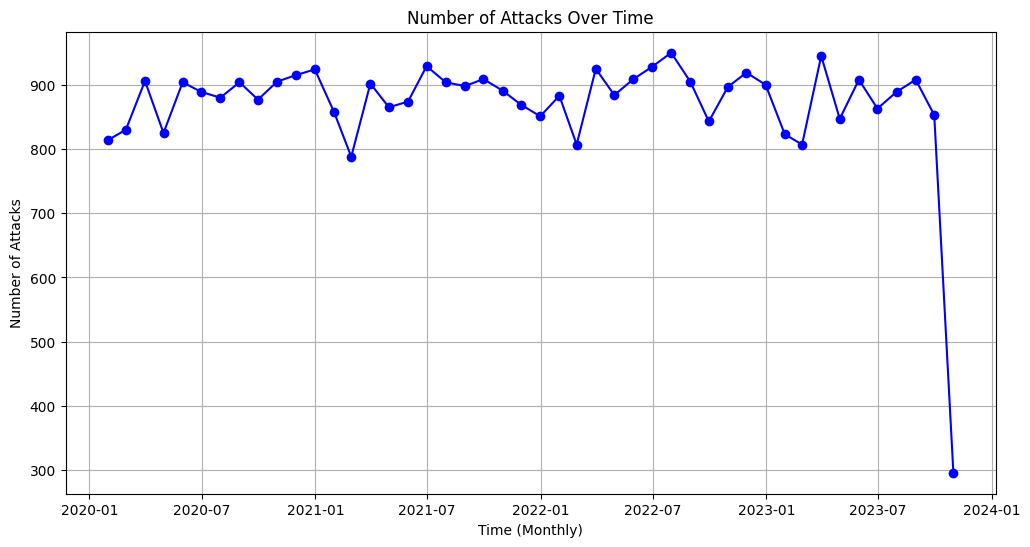

In [14]:
# Time-Series Plot of Attack Counts Over Time
plt.figure(figsize=(12, 6))
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
time_series = df.resample('M', on='Timestamp').size()
plt.plot(time_series.index, time_series.values, marker='o', linestyle='-', color='b')
plt.title('Number of Attacks Over Time')
plt.xlabel('Time (Monthly)')
plt.ylabel('Number of Attacks')
plt.grid(True)
plt.show()

<ipython-input-15-81326610f515>:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  time_series = df.resample('M', on='Timestamp').size()


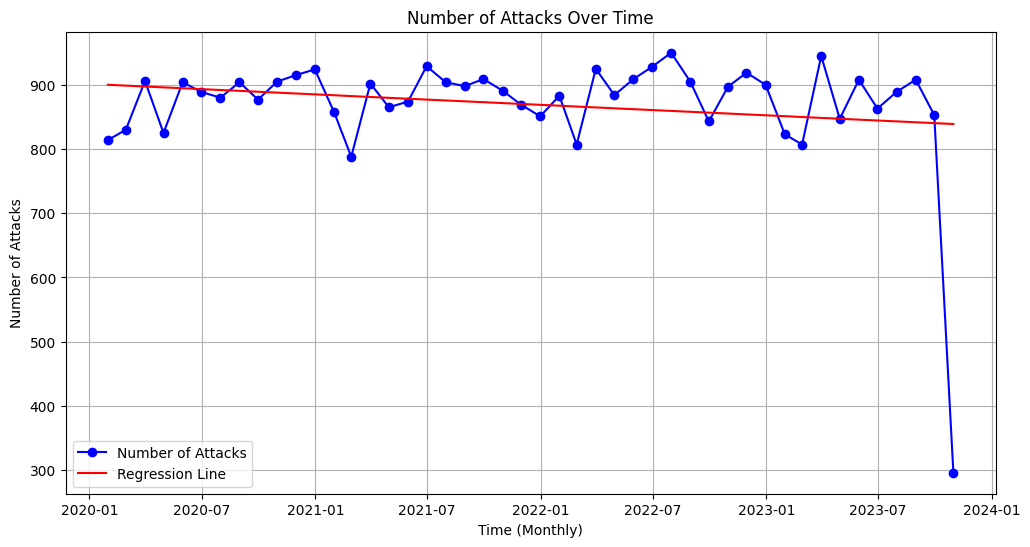

In [15]:
# Ensure Timestamp is in datetime format
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Resample data by month to get attack counts
time_series = df.resample('M', on='Timestamp').size()

# Prepare data for linear regression
time_numeric = np.arange(len(time_series))  # Create a numeric time index
attack_counts = time_series.values.reshape(-1, 1)

# Fit a linear regression model
model = LinearRegression()
model.fit(time_numeric.reshape(-1, 1), attack_counts)

# Predict values for the regression line
regression_line = model.predict(time_numeric.reshape(-1, 1))

# Plot the time-series data with regression line
plt.figure(figsize=(12, 6))
plt.plot(time_series.index, time_series.values, marker='o', linestyle='-', color='b', label='Number of Attacks')
plt.plot(time_series.index, regression_line, color='r', linestyle='-', label='Regression Line')
plt.title('Number of Attacks Over Time')
plt.xlabel('Time (Monthly)')
plt.ylabel('Number of Attacks')
plt.legend()
plt.grid(True)
plt.show()